In [172]:
import numpy as np
import matplotlib.pyplot as plt

In [173]:
x_start = 0
x_end = 1.0
N = 501
dx = (x_end-x_start)/N
CFL = 0.5
M = 500
dt = 1e6
gamma = 1.4
mu0 = 2

Task = 1

In [174]:
def INIT_TEST(U, F, task, fict, dx):
    match task:
        case 1:
            for i in range(N_all):
                if(i*dx <= 0.5*x_end+fict*dx):
                    U[0, i] = 1.0
                    U[1, i] = 1.0
                else:
                    U[0, i] = 0.1
                    U[1, i] = 0.125
                U[2, i] = U[0, i]/(gamma - 1)/U[1, i]
            for i in range(N_all+1):
                F[0, i] = 0.0
                F[1, i] = x_start - fict*dx + i*dx
        case 2:
            for i in range(N_all):
                U[0, i] = 0.4
                U[1, i] = 1.0
                U[2, i] = U[0, i]/(gamma - 1)/U[1, i]
            for i in range(N_all+1):
                if(i*dx <= 0.5*x_end+fict*dx):
                    F[0, i] = -2.0
                else:
                    F[0, i] = 2.0
                F[1, i] = x_start - fict*dx + i*dx
        case 3:
            for i in range(N_all):
                if(i*dx < 0.5*x_end):
                    U[0, i] = 1000.0
                else:
                    U[0, i] = 0.01
                U[1, i] = 1.0
                U[2, i] = U[0, i]/(gamma - 1)/U[1, i]
            for i in range(N_all+1):
                F[0, i] = 0.0
                F[1, i] = x_start - fict*dx + i*dx
        case 4:
            for i in range(N_all):
                if(i*dx < 0.5):
                    U[0, i] = 0.01
                else:
                    U[0, i] = 100
                U[1, i] = 1.0
                U[2, i] = U[0, i]/(gamma - 1)/U[1, i]
            for i in range(N_all+1):
                F[0, i] = 0.0
                F[1, i] = x_start - fict*dx + i*dx
        case 5:
            for i in range(N_all):
                if(i*dx < 0.5):
                    U[0, i] = 460.894
                    U[1, i] = 5.99924
                else:
                    U[0, i] = 46.0950
                    U[1, i] = 5.99242
                U[2, i] = U[0, i]/(gamma - 1)/U[1, i]
            for i in range(N_all+1):
                if(i*dx <= 0.5):
                    F[0, i] = 19.5975
                else:
                    F[0, i] = -6.19633
                F[1, i] = x_start - fict*dx + i*dx
        case 6:
            for i in range(N_all):
                if(i*dx < 0.5):
                    U[1, i] = 1.0
                else:
                    U[1, i] = 0.1
                U[0, i] = 1.0
                U[2, i] = U[0, i]/(gamma - 1)/U[1, i]
            for i in range(N_all+1):
                F[0, i] = 2.0
                F[1, i] = x_start - fict*dx + i*dx

In [175]:
# крест
# 1 фиктивныx узла на границе, фактических !границ! N+1
N_fict = 1
N_all = N + 2*N_fict

# выделение памяти
# U = p, rho, i, m
# F = u, x
U = np.zeros((4, N_all))
F = np.zeros((2, N_all+1))
omega = np.zeros(N_all)
U_hist = np.zeros((M, 4, N_all))
F_hist = np.zeros((M, 2, N_all+1))

# начальные условия, сетка
INIT_TEST(U, F, Task, N_fict, dx)

# считаем массу в каждой ячейке
for i in range(N_all):
    U[3, i] = U[1, i]*(F[1, i+1] - F[1, i])

In [176]:
# считаем
t = 0
for j in range(M):
    # шаг по времени
    min_dt = 1e6
    for i in range(N_all):
        dx = F[1, i+1] - F[1, i]
        dt_temp = (CFL*dx/(abs(F[0, i]) + (gamma*abs(U[0, i]+omega[i])/U[1, i])**0.5))
        if(dt_temp < min_dt):
            min_dt = dt_temp
    dt = min_dt
    t += dt
    u_last = F[0, :].copy()
    # вязкость
    for i in range(N_all):
        # без вязкости
        # omega[i] = 0.0
        # Неймана-Рихтмайера
        # omega[i] = -mu0*U[1, i]*abs(F[0, i+1] - F[0, i])*(F[0, i+1] - F[0, i])
        # Р.Лэттера
        omega[i] = mu0*U[1, i]*(F[0, i+1] - F[0, i])**2 if (F[0, i+1] - F[0, i]) < 0 else 0 
        # omega[i] = mu0*U[3, i] if (F[0, i+1] - F[0, i]) < 0 else 0
    # скорость 
    for i in range(2, N_all-1):
        dx = 0.5*(U[3, i] + U[3, i-1])
        F[0, i] = F[0, i] - ((U[0, i] + omega[i]) - (U[0, i-1] + omega[i-1]))*dt/dx
    # граничные для скорости
    if(Task == 1 or Task == 3 or Task == 4):
        F[0, 1] = 0.0
        F[0, N_all-1] = 0.0
    elif (Task == 2):
        F[0, 1] = -2.0
        F[0, N_all-1] = 2.0
    elif(Task == 5):
        F[0, 1] = 19.5975
        F[0, N_all-1] = -6.19633
    F[0, 0] = -F[0, 2] + 2*F[0, 1]
    F[0, N_all] = -F[0, N_all-2] + 2*F[0, N_all-1]
    # координата
    for i in range(N_all+1):
        F[1, i] = F[1, i] + F[0, i]*dt
    # плотность
    for i in range(1, N_all-1):
        dx = U[3, i]
        U[1, i] = U[1, i]/(U[1, i]*(F[0, i+1] - F[0, i])*dt/dx + 1.0)
        # U[1, i] = U[3, i]/(F[1, i+1] - F[1, i])
    for i in range(N_fict):
        U[1, i] = U[1, N_fict]
        U[1, N_all-i-1] = U[1, N_all-N_fict-1]
    # энергия
    pc = np.zeros(N_all+1)
    # давление на границах
    for i in range(1, N_all):
        pc[i] = 0.5*(U[0, i] + omega[i] + U[0, i-1] + omega[i-1])
        # pc[i] = 0.5*(U[0, i] + U[0, i-1])
    for i in range(1, N_all-1):
        dx = U[3, i]
        # неконсервативный
        # print(f'{(U[1, i]*(F[0, i+1] - F[0, i])*(gamma - 1.0)*dt/dx+1.0):.50f}')
        # U[2, i] = (U[2, i])/(U[1, i]*(F[0, i+1] - F[0, i])*(gamma - 1.0)*dt/dx+1.0)
        # типа консервативные
        U[2, i] = U[2, i] - dt*(F[0, i+1]*pc[i+1] - F[0, i]*pc[i])/dx +\
             ((u_last[i+1] + u_last[i])**2.0)/8.0 - ((F[0, i+1] + F[0, i])**2.0)/8.0 
    for i in range(N_fict):
        U[2, i] = U[2, 1]
        U[2, N_all-i-N_fict] = U[2, N_all-N_fict-1]
    # давление
    for i in range(N_all):
        U[0, i] = U[1, i]*(gamma-1.0)*U[2, i]
        
    U_hist[j] = U.copy()
    F_hist[j] = F.copy()

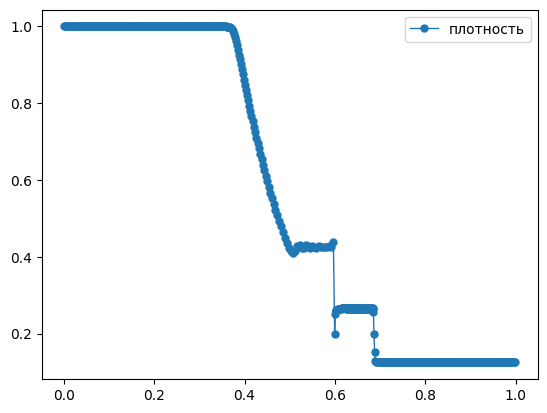

In [181]:
time = 499
x_grid = np.zeros(N_all)
for i in range(N_all):
    x_grid[i] = 0.5*(F_hist[time, 1, i+1] + F_hist[time, 1, i])

plt.plot(x_grid[N_fict:N+N_fict], U_hist[time, 1, N_fict:N+N_fict], 'o-', lw = 1, markersize = 5, label = "плотность")
# plt.plot(x_grid[N_fict:N+N_fict], U_hist[time, 0, N_fict:N+N_fict], 'o-', lw = 1, markersize = 5, label = "давление")
# plt.plot(F_hist[time, 1, 1:N_all], F_hist[time, 0, 1:N_all], 'o-', lw = 1, markersize = 5, label ="скорость")
# plt.plot(U_hist[time, 1], label = "плотность")
# plt.plot(U_hist[time, 0], label = "давление")
# plt.plot(F_hist[time, 0], label ="скорость")
plt.legend()
plt.show()

In [178]:
def fsol(x, t):
    if x < 2*t + 0.5:
        return 1
    return 0.1

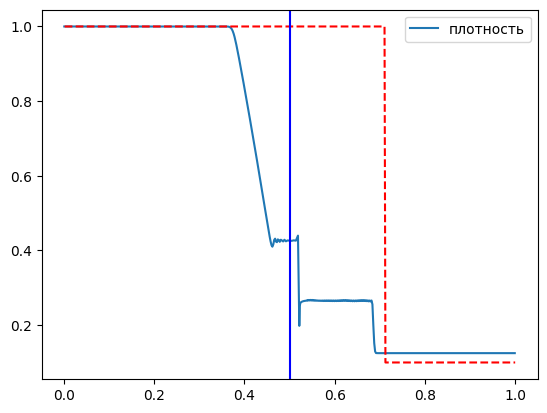

In [179]:
time = 499
plt.plot(x_grid[N_fict:N+N_fict], U_hist[time, 1, N_fict:N+N_fict], label = "плотность")
x = F_hist[time, 1, 2:N_all:] - dx/2
sol = []
for i in x:
    sol.append(fsol(i, t))
sol = np.array(sol)
plt.plot(F_hist[time, 1, 2:N_all:] - dx/2, sol, 'r--')
plt.axvline(0.5, c = 'b')
plt.legend()
plt.show()